In [194]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from tsp import AnnealingSolver
from mst_prim import prim_mst, createRoutes
from leach import LeachSolver
from nemo import evaluate_nemo
import util
from util import lighten_color
import seaborn as sns
from util import centroid_label, ch_label, coordinator_label, worker_label, ccolor, cmarker
from topology import get_lognorm_hist
import topology

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Topology Setup

In [196]:
seed = 4
np.random.seed(seed)

device_number = 1000 + 1
avg = 50
c_capacity = 50
max_resources = device_number * avg - c_capacity

X_dim_range = [0, 100]
Y_dim_range = [-50, 50]
centers = 40

H, bins = get_lognorm_hist()
coords_df = topology.coords_sim(1000, centers, X_dim_range, Y_dim_range, seed)
coord_dict = {"sim(1000)": coords_df}

df_dict_topologies = topology.create_topologies_from_dict(coord_dict, H, max_resources, c_capacity,
                                                          weights=(1, avg * 2), dist="lognorm", with_clustering=True,
                                                          kmin=10, kmax=30, kseed=10)

Creating df for sim(1000)
Optimal k is 21
Done


In [197]:
t_label = "sim(1000)"
prim_df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
prim_df["weight_1"] = 1
prim_df["weight_2"] = 2
coords = prim_df[["x", "y"]].to_numpy()

eval_matrix = {}
prim_df

,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,...,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster,weight_1,weight_2
0,19.383905,7.406120,0.000000,coordinator,9223372036854775807,0,50,50,50,50,...,50,50,50,50,50,50,50,-1,1,2
1,67.743232,-14.007158,52.888118,worker,9223372036854775807,1,50,48,50,54,...,41,58,47,107,47,56,45,8,1,2
2,5.220579,-15.467092,26.903228,worker,9223372036854775807,1,50,53,48,43,...,36,62,50,108,47,63,0,0,1,2
3,43.521014,41.129903,41.471599,worker,9223372036854775807,5,50,51,55,52,...,62,38,32,33,32,37,7,13,1,2
4,14.195029,1.412734,7.927491,worker,9223372036854775807,2,50,49,50,61,...,70,33,53,61,21,171,0,14,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,14.908514,-3.352142,11.652010,worker,9223372036854775807,2,50,51,46,46,...,52,35,55,27,63,21,112,14,1,2
997,39.672067,34.499402,33.847532,worker,9223372036854775807,60,50,51,51,44,...,65,55,34,27,23,14,28,13,1,2
998,40.609309,23.985392,26.933066,worker,9223372036854775807,33,50,53,54,56,...,67,52,79,28,23,37,17,1,1,2
999,31.878351,34.859971,30.163307,worker,9223372036854775807,4,50,51,50,55,...,68,37,30,99,17,92,0,4,1,2


In [198]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())
colors, light_colors, palette = util.get_color_list(opt_k)
palette

Required: 6588 Available: 50050


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]

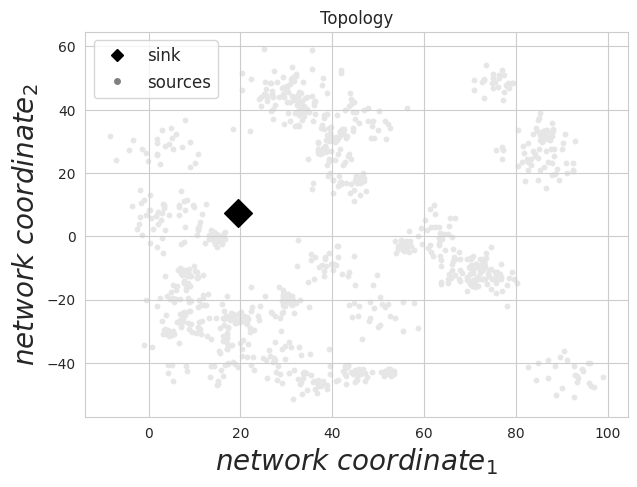

In [207]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
ax1 = util.plot_topology(ax1, prim_df, scale_fac=0.1)

#ax1.set_xlim(X_dim_def)
#ax2.set_xlim(X_dim_def)

#ax1.set_ylim(Y_dim_def)
#ax2.set_ylim(Y_dim_def)

X_dim = ax1.get_xlim()
Y_dim = ax1.get_ylim()

plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs.svg", bbox_inches="tight")

plt.show()

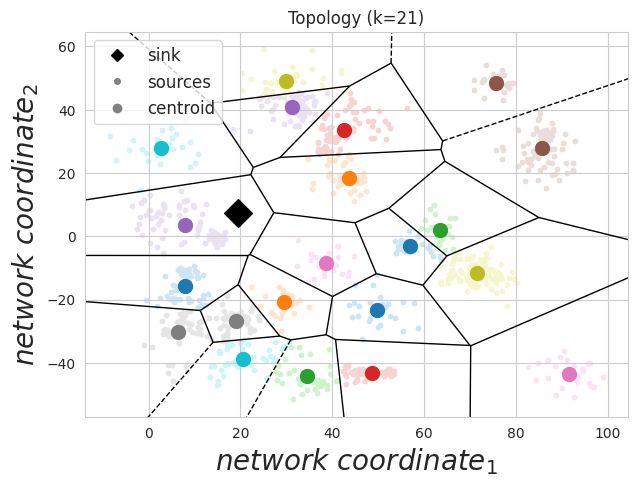

In [206]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))

ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.1,
                         plot_voronoi=True, plot_centroid=True)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs_grouped.svg", bbox_inches="tight")

plt.show()

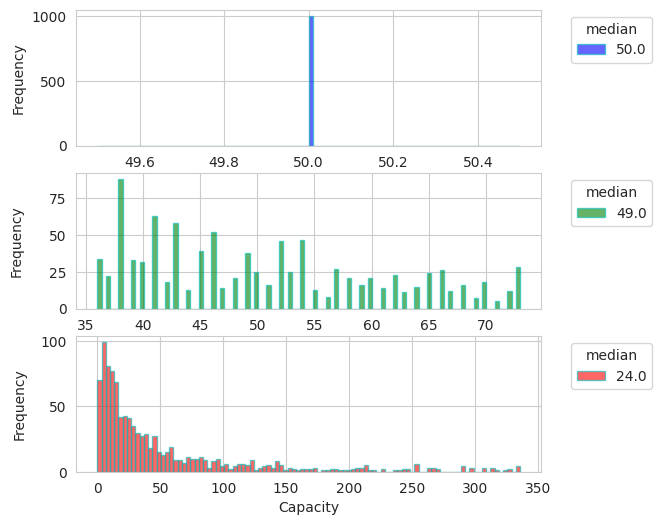

In [208]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6))

i = 100
prim_df["capacity_" + str(i)].plot.hist(ax=ax1, bins=100, alpha=0.6, color='b', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

i = 50
prim_df["capacity_" + str(i)].plot.hist(ax=ax2, bins=100, alpha=0.6, color='g', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

i = 1
prim_df["capacity_" + str(i)].plot.hist(ax=ax3, bins=100, alpha=0.6, color='r', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

ax1.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.set_xlabel("Capacity")

# Set y-axis label with padding
ax2.set_ylabel("Frequency", labelpad=18)
ax3.set_ylabel("Frequency", labelpad=10)
plt.savefig("plots/sim_1000/capacity_dist.svg", bbox_inches="tight")

plt.show()

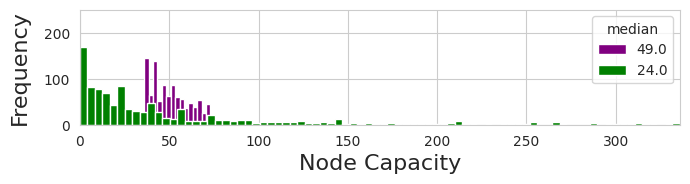

In [209]:
fig, (merged_ax) = plt.subplots(1, 1, figsize=(7, 2))

i = 50
prim_df["capacity_" + str(i)].plot.hist(ax=merged_ax, bins=15, alpha=1, color='purple',
                                        label=prim_df["capacity_" + str(i)].median())

#i = 10
#prim_df["capacity_"+str(i)].plot.hist(ax=merged_ax, bins=40, alpha=1, color='orange', label=prim_df["capacity_"+str(i)].median())

i = 1
prim_df["capacity_" + str(i)].plot.hist(ax=merged_ax, bins=80, alpha=1, color='green',
                                        label=prim_df["capacity_" + str(i)].median())

merged_ax.legend(title='median', loc='upper right')
merged_ax.set_xlabel("Node Capacity")

# Set y-axis label with padding
merged_ax.set_ylabel("Frequency", labelpad=10)

# Set the same x-axis limits for both histograms
xlim = (prim_df["capacity_1"].min(), prim_df["capacity_1"].max())
merged_ax.set_xlim(xlim)
merged_ax.set_ylim([0, 250])

merged_ax.yaxis.label.set_size(16)
merged_ax.xaxis.label.set_size(16)
#merged_ax.tick_params(axis='x', labelsize=20)

# Adjust figure layout for better display
fig.tight_layout()

plt.savefig("plots/sim_1000/capacity_dist.svg", bbox_inches="tight")
plt.show()

Medians from  50  to  25


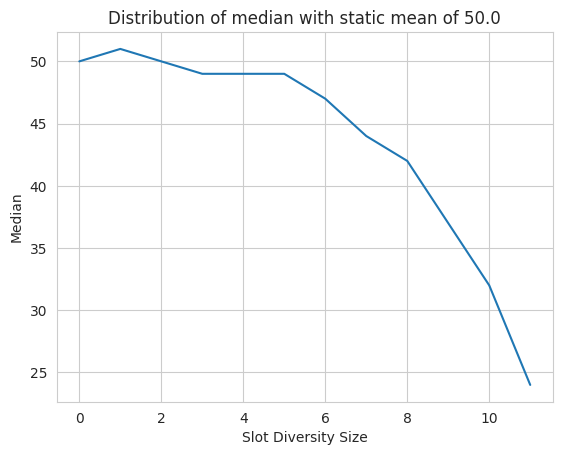

In [210]:
medians = []
mean = np.floor(prim_df["capacity_" + str(1)].mean())

for col in slot_columns:
    medians.append(prim_df[col].median())

medians = np.array(medians)
plt.plot(np.arange(len(medians)), medians)

first_med_label = "50"
last_med_label = "25"
print("Medians from ", first_med_label, " to ", last_med_label)

#print(load_dict)
plt.title("Distribution of median with static mean of " + str(mean))
plt.ylabel("Median")
plt.xlabel("Slot Diversity Size")
plt.show()

### Experiment 1: Send all data directly to coordinator


In [46]:
#first node is the coordinator
latency_hist = np.zeros(device_number)

for i in range(0, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    latency_hist[i] = np.linalg.norm(coords[i] - c_coords)

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    #coordinator receives 1 packet from each
    received_packets_hist[0] = received_packets_hist[0] + 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)
print(df_stats)
eval_matrix["dt"] = df_stats.copy()

      latency_distribution  received_packets
0                 0.000000            1000.0
1                52.888118               0.0
2                26.903228               0.0
3                41.471599               0.0
4                 7.927491               0.0
...                    ...               ...
996              11.652010               0.0
997              33.847532               0.0
998              26.933066               0.0
999              30.163307               0.0
1000             36.664622               0.0

[1001 rows x 2 columns]


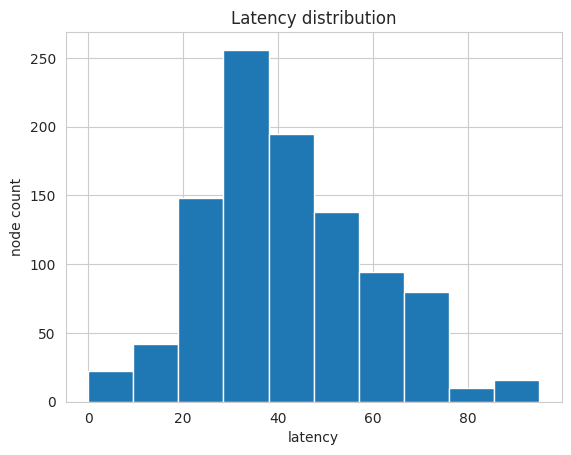

In [47]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
plt.show()

In [48]:
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"]
print("Distribution of workload: ", 1, "/", device_number, "=", round(len(df_packets) / device_number * 100, 5), "%")

Distribution of workload:  1 / 1001 = 0.0999 %


### Experiment 1: LEACH Protocol

In [102]:
seed = 10
np.random.seed(seed)
latency_hist_sum = None
received_packets_hist_sum = None
leach_runs = 20
run = 1
df_stats_leach = []
num_leach_clusters = int(0.1 * device_number)

for i in range(leach_runs):
    print("LEACH run", run)
    if run == leach_runs:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords, seed=seed)
    else:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords)

    leach_labels, ch_indexes, latency_hist, received_packets_hist = leachSolver.leachClustering()

    if latency_hist_sum is None:
        latency_hist_sum = latency_hist
    else:
        latency_hist_sum = latency_hist_sum + latency_hist

    statistics = {"latency_distribution": latency_hist,
                  "received_packets": received_packets_hist}
    df_stats = pd.DataFrame(statistics)
    df_stats_leach.append(df_stats.copy())
    run = run + 1

print("Number of clusters = ", len(ch_indexes))
print(ch_indexes)

LEACH run 1
LEACH run 2
LEACH run 3
LEACH run 4
LEACH run 5
LEACH run 6
LEACH run 7
LEACH run 8
LEACH run 9
LEACH run 10
LEACH run 11
LEACH run 12
LEACH run 13
LEACH run 14
LEACH run 15
LEACH run 16
LEACH run 17
LEACH run 18
LEACH run 19
LEACH run 20
Number of clusters =  100
[586, 34, 440, 495, 592, 16, 212, 474, 833, 504, 844, 285, 670, 831, 165, 36, 534, 502, 336, 78, 256, 976, 979, 764, 370, 46, 431, 881, 143, 618, 364, 391, 432, 291, 847, 692, 269, 468, 179, 703, 311, 678, 372, 137, 963, 787, 973, 246, 451, 629, 385, 975, 597, 5, 242, 138, 200, 932, 960, 550, 375, 791, 920, 953, 322, 683, 563, 462, 447, 482, 67, 669, 599, 333, 865, 514, 161, 863, 230, 423, 245, 38, 33, 509, 309, 838, 622, 674, 74, 547, 876, 83, 154, 394, 581, 384, 616, 908, 116, 795]


In [103]:
df_stats

,latency_distribution,received_packets
0,0.000000,100.0
1,54.757736,0.0
2,33.345774,0.0
3,42.248460,0.0
4,7.947560,0.0
...,...,...
996,11.372914,0.0
997,35.879992,0.0
998,27.308469,0.0
999,37.339163,0.0


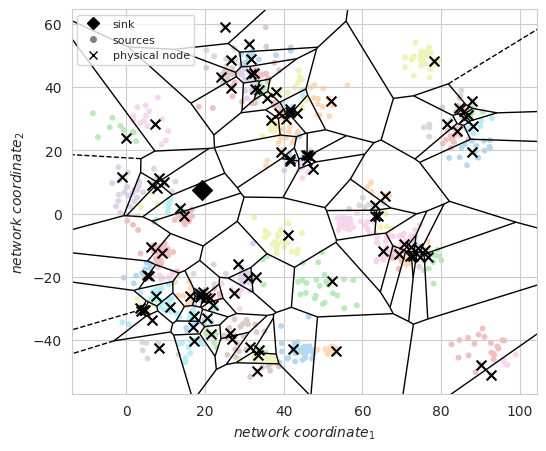

In [150]:
fig = plt.figure(figsize=(6, 5)).gca()
cluster_head_coords = coords[ch_indexes]

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

fig.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=100)
fig.scatter(cluster_head_coords[:, 0], cluster_head_coords[:, 1], s=50, color="black", marker="x", zorder=2)
fig.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.3) for x in leach_colors[leach_labels]],
            zorder=-1)

plt.legend(handles=[coordinator_label, worker_label, ch_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

vor = Voronoi(cluster_head_coords)
voronoi_plot_2d(vor, ax=fig, point_size=16, color="red", show_vertices=False, show_points=False)

plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.savefig("plots/sim_1000/leach.svg")
plt.show()

count    1001.000000
mean       44.493804
std        17.886776
min         0.000000
25%        31.775072
50%        41.302504
75%        56.000000
max       101.639423
Name: latency_distribution, dtype: float64


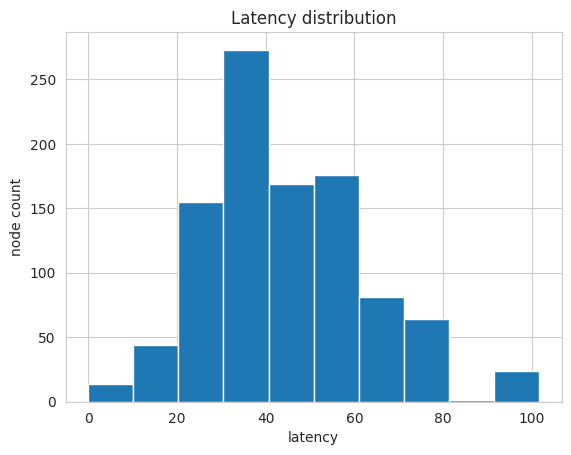

In [52]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

In [53]:
eval_matrix["leach"] = df_stats.copy()

### Experiment 2a: NEMO Aggregation with Density-based Grouping

### Identify parameters

In [168]:
# fixed params
max_levels = 50
slot_col = "capacity_100"
weight_col = "weight"

# dynamic params
num_points = 9
start = 0.1
end = 0.9
hyperparam_values_1 = np.linspace(start, end, num_points)
hyperparam_values_2 = np.linspace(start, end, num_points)
X, Y = np.meshgrid(hyperparam_values_1, hyperparam_values_2)

# Initialize an array to store performance values
perc_lat_values = np.zeros_like(X)
mean_lat_values = np.zeros_like(X)

for i in range(num_points):
    for j in range(num_points):
        eval_dict, df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, [slot_col], weight_col, merge_factor=X[i, j],
                                                                  step_size=Y[i, j], max_levels=max_levels,
                                                                  with_eval=True)
        sv = eval_dict[slot_col]["latency_distribution"].sort_values()
        perc_lat = round(sv.quantile(0.9), 2)
        mean_lat = round(sv.mean(), 2)
        print(perc_lat, mean_lat)

        perc_lat_values[i, j] = perc_lat
        mean_lat_values[i, j] = mean_lat

Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.1
Evaluating for capacity_100
104.31 80.2
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.2
Evaluating for capacity_100
104.31 80.2
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.30000000000000004
Evaluating for capacity_100
96.17 74.84
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.4
Evaluating for capacity_100
89.86 71.43
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.5
Evaluating for capacity_100


KeyboardInterrupt: 

merge factor and step size for minimum latency (90P): (X=0.9, Y=0.1) 71.15
merge factor and step size for minimum latency (mean): (X=0.9, Y=0.1) 47.37


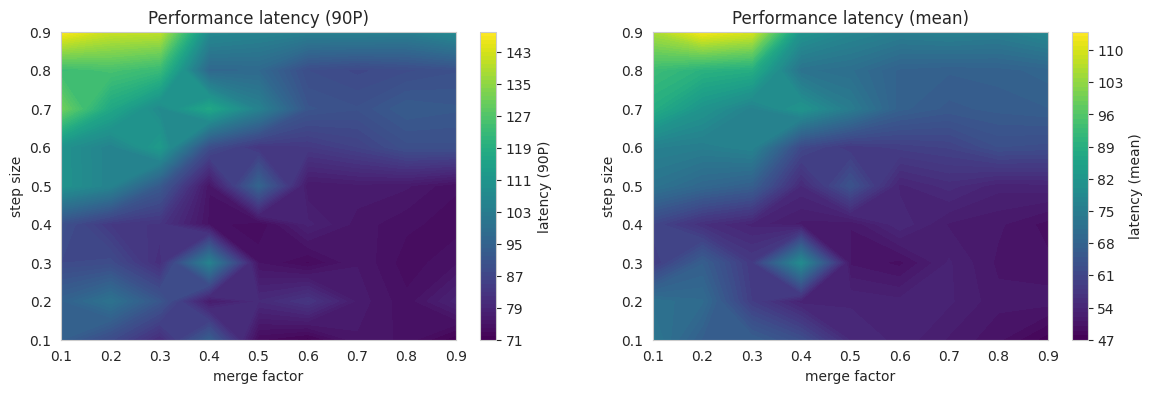

In [111]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

for i, values in enumerate([perc_lat_values, mean_lat_values]):
    if i == 0:
        label = "latency (90P)"
    elif i == 1:
        label = "latency (mean)"
    else:
        label = "undefined"

    # Find the indices of the minimum Z value
    min_index = np.unravel_index(np.argmin(values), values.shape)
    # Use the indices to get the corresponding X and Y values
    min_X = X[min_index]
    min_Y = Y[min_index]
    print(f"merge factor and step size for minimum {label}: (X={min_X}, Y={min_Y})", values[min_index])

    # Create a contour plot
    ax = axs[i]
    contour = ax.contourf(X, Y, values, levels=80, cmap='viridis')

    # Create a colorbar and set the label
    colorbar = plt.colorbar(contour)
    colorbar.set_label(label)

    ax.set_title(f"Performance {label}")
    ax.set_xlabel('merge factor')
    ax.set_ylabel('step size')

plt.show()

In [211]:
param_dict = {
    "weight_1": {"merge_factor": 0.4, "step_size": 0.2},
    "weight_2": {"merge_factor": 0.4, "step_size": 0.2},
    "weight": {"merge_factor": 0.9, "step_size": 0.1}
}

In [212]:
# for the eval for weights regarding latency
weight_cols = ["weight_2", "weight"]
for weight_col in weight_cols:
    eval_name = "nemo_dc" + "_" + weight_col
    eval_matrix[eval_name], df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, ["capacity_100", "capacity_1"],
                                                                           weight_col,
                                                                           merge_factor=param_dict[weight_col][
                                                                               "merge_factor"],
                                                                           step_size=param_dict[weight_col][
                                                                               "step_size"], with_eval=True)

Starting nemo for: c=capacity_100, w=weight_2, l=20, step_size=0.2, merge_factor=0.4
Evaluating for capacity_100
Starting nemo for: c=capacity_1, w=weight_2, l=20, step_size=0.2, merge_factor=0.4
Evaluating for capacity_1
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.1, merge_factor=0.9
Evaluating for capacity_100
Starting nemo for: c=capacity_1, w=weight, l=20, step_size=0.1, merge_factor=0.9
Evaluating for capacity_1


In [213]:
# for the plots and vanilla NEMO
eval_name = "nemo_dc"
slot_col = "capacity_100"
weight_col = "weight_1"
df_dict_1, opt_dict_1, limits_dict_1 = evaluate_nemo(prim_df, [slot_col], weight_col, max_levels=1,
                                                     merge_factor=param_dict[weight_col]["merge_factor"],
                                                     step_size=param_dict[weight_col]["step_size"], with_eval=False)
eval_matrix[eval_name], df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, slot_columns, weight_col,
                                                                       merge_factor=param_dict[weight_col][
                                                                           "merge_factor"],
                                                                       step_size=param_dict[weight_col]["step_size"],
                                                                       with_eval=True)

Starting nemo for: c=capacity_100, w=weight_1, l=1, step_size=0.2, merge_factor=0.4
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.2, merge_factor=0.4
Evaluating for capacity_100
Starting nemo for: c=capacity_90, w=weight_1, l=20, step_size=0.2, merge_factor=0.4
Evaluating for capacity_90
Starting nemo for: c=capacity_80, w=weight_1, l=20, step_size=0.2, merge_factor=0.4
Evaluating for capacity_80
Starting nemo for: c=capacity_70, w=weight_1, l=20, step_size=0.2, merge_factor=0.4
Evaluating for capacity_70
Starting nemo for: c=capacity_60, w=weight_1, l=20, step_size=0.2, merge_factor=0.4
Evaluating for capacity_60
Starting nemo for: c=capacity_50, w=weight_1, l=20, step_size=0.2, merge_factor=0.4
Evaluating for capacity_50
Starting nemo for: c=capacity_40, w=weight_1, l=20, step_size=0.2, merge_factor=0.4
Evaluating for capacity_40
Starting nemo for: c=capacity_30, w=weight_1, l=20, step_size=0.2, merge_factor=0.4
Evaluating for capacity_30
Starting nemo for: c=capac

In [214]:
df = df_dict[slot_col]
df

,oindex,x,y,type,cluster,total_weight,used_weight,total_capacity,free_capacity,level,parent,latency,load
0,1,67.743232,-14.007158,worker,8,1,1,50,50,3,194,0.000000,0
1,2,5.220579,-15.467092,worker,0,1,1,50,50,0,132,30.135747,0
2,3,43.521014,41.129903,worker,13,5,1,50,50,0,58,41.974374,0
3,4,14.195029,1.412734,worker,14,2,1,50,50,0,577,14.177019,0
4,5,84.126722,25.980212,worker,5,1,1,50,50,0,180,68.254181,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,14.908514,-3.352142,worker,14,2,1,50,50,0,458,20.180961,0
996,997,39.672067,34.499402,worker,13,60,1,50,50,0,58,34.427751,0
997,998,40.609309,23.985392,worker,1,33,1,50,50,0,238,38.048412,0
998,999,31.878351,34.859971,worker,4,4,1,50,50,0,123,37.425445,0


In [215]:
df[df["oindex"] == 58]["parent"].to_numpy()

array([255])

In [216]:
df[df["parent"] == df["oindex"]]

,oindex,x,y,type,cluster,total_weight,used_weight,total_capacity,free_capacity,level,parent,latency,load


In [217]:
df[df["parent"] == 0]

,oindex,x,y,type,cluster,total_weight,used_weight,total_capacity,free_capacity,level,parent,latency,load
24,25,82.599536,-41.295540,worker,6,2,1,50,26,2,0,79.800173,24
179,180,75.610322,27.287765,worker,5,1,1,50,26,2,0,59.637989,24
227,228,32.192442,-9.379523,worker,16,1,1,50,47,2,0,21.114366,3
254,255,34.596542,24.514620,worker,1,21,1,50,42,2,0,22.893778,8
276,277,53.701273,-1.423096,worker,20,3,1,50,17,2,0,35.434966,33
572,573,46.355946,-32.517935,worker,10,3,1,50,0,2,0,48.181129,50
888,889,16.078907,-21.437955,worker,7,3,1,50,45,2,0,29.032804,5
947,948,10.764356,2.696029,worker,14,1,1,50,45,2,0,9.822504,5


In [218]:
# check -> should be empty
df_overloaded = df.groupby(['parent'])['used_weight'].sum().copy().reset_index()
df_join = df[["oindex", "total_capacity", "free_capacity"]]
result = pd.merge(df_join, df_overloaded, left_on='oindex', right_on='parent', how='inner')
result["delta"] = result["total_capacity"] - result["used_weight"]
result[result["delta"] < 0]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [219]:
# check -> should be empty
result[result["delta"] != result["free_capacity"]]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [220]:
result

,oindex,total_capacity,free_capacity,parent,used_weight,delta
0,25,50,26,25,24,26
1,58,50,1,58,49,1
2,123,50,43,123,7,43
3,132,50,1,132,49,1
4,175,50,0,175,50,0
5,180,50,26,180,24,26
6,194,50,6,194,44,6
7,223,50,49,223,1,49
8,228,50,47,228,3,47
9,238,50,0,238,50,0


In [221]:
#create greedy aggregation tree
cluster_coords = centroids
cluster_coords_with_crd = np.column_stack((c_coords, cluster_coords.T)).T

mst = prim_mst(cluster_coords_with_crd)

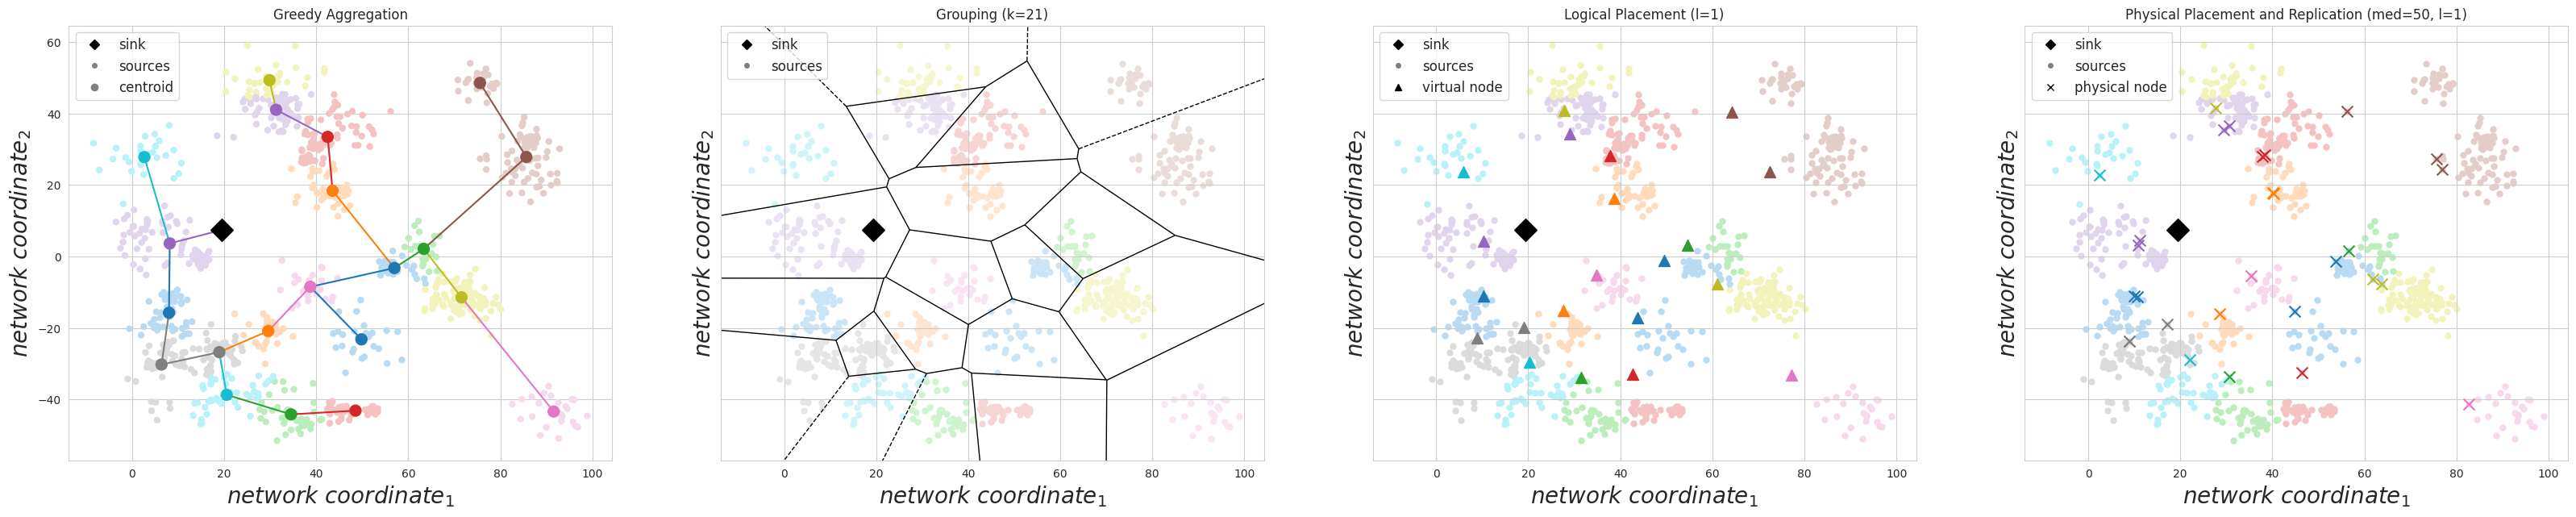

In [222]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")

lval = 0.28
leg_size = 12
symbol_size = 100
scale_fac = 0.25
axis_label_size = 20

labels = prim_df["cluster"]

# plot greedy approach from MST
for i in range(1, len(mst)):
    point1 = cluster_coords_with_crd[i]
    point2 = cluster_coords_with_crd[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax1.plot(x_values, y_values, zorder=2, color=colors[i - 1])

ax1.scatter(coords[0, 0], coords[0, 1], s=2 * symbol_size, color=ccolor, marker=cmarker, zorder=10)
ax1.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=symbol_size, color=colors[:len(cluster_coords)], zorder=3)
# in case all coords shall be plotted
ax1.scatter(coords[:, 0], coords[:, 1], s=scale_fac * symbol_size,
            color=[lighten_color(x, lval) for x in colors[labels]])

lcentroid = Line2D([], [], color="blue", marker='o', linestyle='None', label='centroid')
ax1.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1),
           fontsize=leg_size)

ax1.set_xlabel('$network$ $coordinate_1$', fontsize=axis_label_size)
ax1.set_ylabel('$network$ $coordinate_2$', fontsize=axis_label_size)
ax1.set_title('Greedy Aggregation')

#plot grouping
util.plot_topology(ax2, prim_df, colors, title='Grouping (k=' + str(opt_k) + ")", plot_voronoi=True, leg_size=leg_size,
                   symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size)

# TODO: unify the two below plots into a single one
#plot logical nodes (optima) of different groups
# util.plot2(ax3, prim_df, df_dict[slot_col], colors, lval=lval, show_centroids=True)
util.plot_optimum(ax3, prim_df, opt_dict[slot_col], colors, lval=lval, plot_centroid=False, plot_lines=False,
                  leg_size=leg_size, symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size)
# plot physical nodes
util.plot(ax4, prim_df, df_dict_1[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=False,
          leg_size=leg_size, symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size)

plt.xlim(X_dim)
plt.ylim(Y_dim)
ax3.set_title("Logical Placement (l=1)")
ax4.set_title("Physical Placement and Replication (med=" + first_med_label + ", l=1)")

plt.savefig("plots/sim_1000/nemo_phases.svg", bbox_inches="tight")
plt.show()

Starting nemo for: c=capacity_10, w=weight_2, l=1, step_size=0.2, merge_factor=0.4
Starting nemo for: c=capacity_10, w=weight_2, l=2, step_size=0.2, merge_factor=0.4
Starting nemo for: c=capacity_10, w=weight_2, l=3, step_size=0.2, merge_factor=0.4


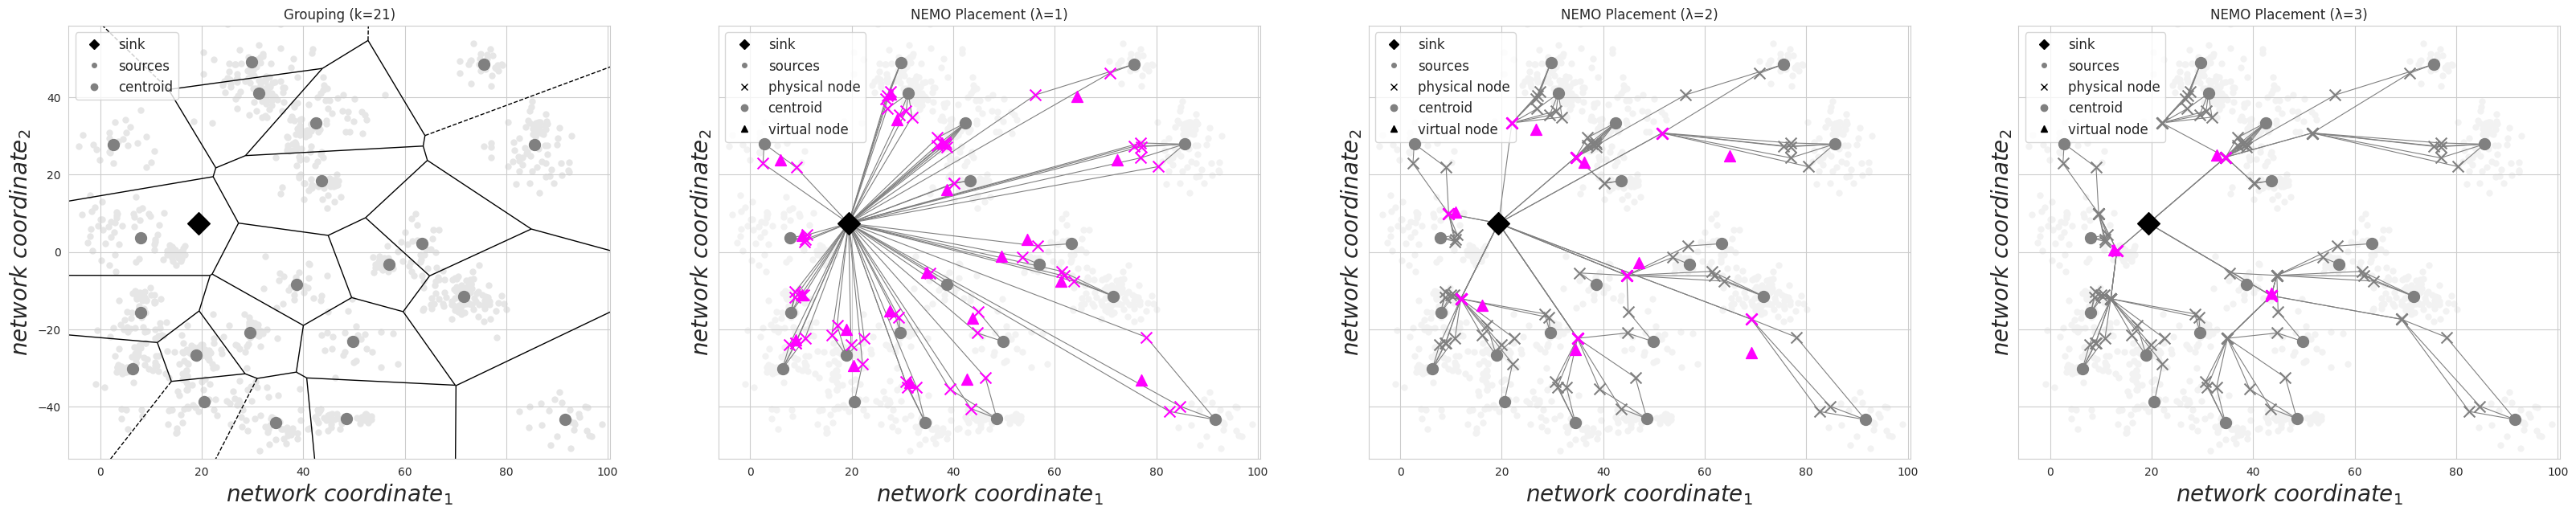

In [226]:
levels = [1, 2, 3]
fig, axs = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.1
weight_col_plot = "weight_2"
slot_col_plot = "capacity_10"
single_color = "grey"

util.plot_topology(axs[0], prim_df, None, title='Grouping (k=' + str(opt_k) + ")", plot_voronoi=True, plot_centroid=True, leg_size=leg_size,
                   symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size,
                   point_color=single_color, centroid_color=single_color)

for i, level in enumerate(levels):
    df_dict_i, opt_dict_i, limits_dict_i = evaluate_nemo(prim_df, [slot_col_plot], weight_col_plot,
                                                         merge_factor=param_dict[weight_col_plot]["merge_factor"],
                                                         step_size=param_dict[weight_col_plot]["step_size"],
                                                         max_levels=level, with_eval=False)
    
    util.plot_with_single_color(axs[i + 1], prim_df, df_dict_i[slot_col_plot], single_color,
                                opt_dict=opt_dict_i[slot_col_plot], leg_size=leg_size, symbol_size=symbol_size,
                                scale_fac=scale_fac, axis_label_size=axis_label_size, lval=lval, plot_centroids=True,
                                plot_lines=True, highlight_color="magenta")
    axs[i+1].set_title(f"NEMO Placement (λ={str(level)})")

plt.show()

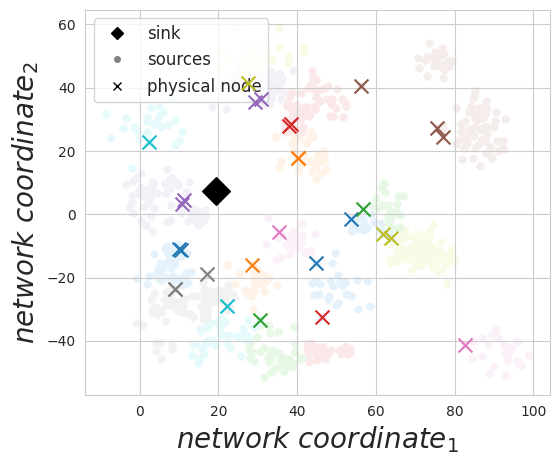

In [227]:
ax = plt.figure(figsize=(6, 5)).gca()

#uncomment this to plot nemo grouping
#ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
#ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
#ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)
#ax2.set_title('Grouping (k=' + str(opt_k) + ")")
#fig.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

#uncomment this for nemo placement
util.plot(ax, prim_df, df_dict_1[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=False)

#uncomment this for nemo redistribution
#util.plot(fig, new_paths_flat[slot_col], agg_dict_flat[slot_col], c_coords, cluster_coords, coords, colors, labels, changed_labels=reassigned_clussters, lval=lval)


ax.set_xlabel('$network$ $coordinate_1$')
ax.set_ylabel('$network$ $coordinate_2$')

plt.savefig("plots/sim_1000/nemo_placement.svg", bbox_inches="tight")

Distribution of workload:  4.5954 %


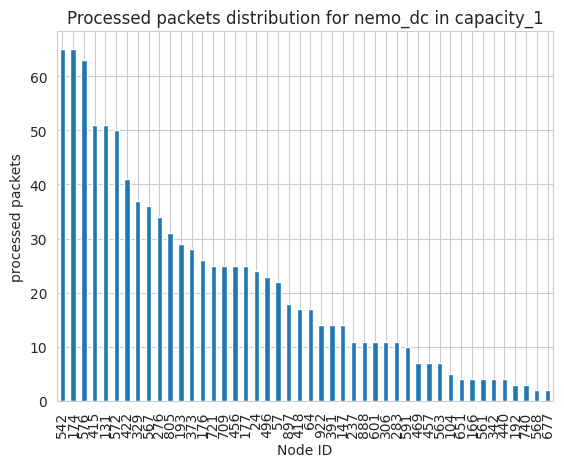

In [228]:
eval_col = list(eval_matrix[eval_name])[-1]
df_stats = eval_matrix[eval_name][eval_col]
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
df_packets.plot.bar()

print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")
plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution for " + eval_name + " in " + str(eval_col))
plt.show()

### Experiment 3: Calculating the minimimal chain which is equivallent to the TSP
#### Corresponds to to the optimal chain of chain-based protocol solutions like PEGASIS or CREEC

In [36]:
# the adjacency matrix for the plane
df = prim_df.copy()
t_coords = coords[0::]
solver = AnnealingSolver()
route, valueBest, nCities, recordBest, recordNow = solver.solve_tsp(t_coords)

i:0, t(i):10.00, valueNow:38813.0, valueBest:38813.0
i:10, t(i):3.49, valueNow:22202.0, valueBest:22202.0
i:20, t(i):1.22, valueNow:17903.0, valueBest:17903.0
i:30, t(i):0.42, valueNow:15618.0, valueBest:15618.0
i:40, t(i):0.15, valueNow:14545.0, valueBest:14545.0
i:50, t(i):0.05, valueNow:13716.0, valueBest:13716.0
i:60, t(i):0.02, valueNow:13123.0, valueBest:13123.0


In [37]:
print(route)

[ 32 251 242 ... 353 148 927]


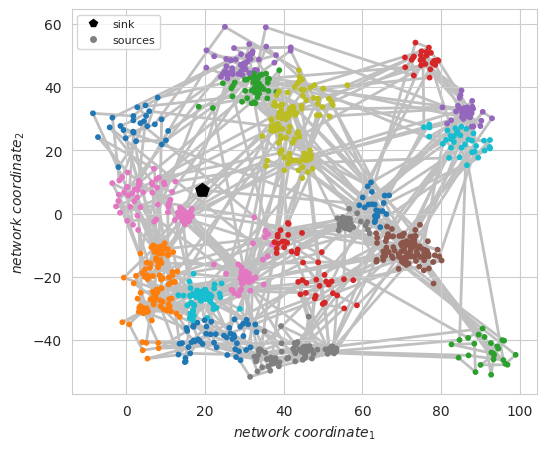

In [38]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(0, len(route) - 1):
    point1 = coords[route[i]]
    point2 = coords[route[i + 1]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=colors[labels], s=10, ax=fig)
plt.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/sim_1000/chain_50n.svg", bbox_inches="tight")
plt.show()

In [39]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
received_packets_hist = np.zeros(device_number)
ind_cor = np.where(route == 0)[0][0]
print("Coordinator is on place ", ind_cor, " in route.")

for i in range(0, len(route)):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = []
    if i < ind_cor:
        lat_route = route[i:ind_cor + 1]
    elif i > ind_cor:
        lat_route = route[i:ind_cor - 1:-1]
    else:
        continue

    start_idx = lat_route[0]
    received_packets_hist[lat_route[1]] += 1
    for j in range(1, len(lat_route)):
        end_idx = lat_route[j]
        dist = dist + np.linalg.norm(coords[start_idx] - coords[end_idx])
        start_idx = end_idx
    latency_hist[i] = dist

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

Coordinator is on place  478  in route.


In [40]:
print(df_stats["received_packets"])

0       2.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
996     1.0
997     1.0
998     1.0
999     1.0
1000    1.0
Name: received_packets, Length: 1001, dtype: float64


count    1001.000000
mean     3256.182515
std      1864.015956
min         0.000000
25%      1633.526617
50%      3321.494391
75%      4853.246358
max      6503.195805
Name: latency_distribution, dtype: float64


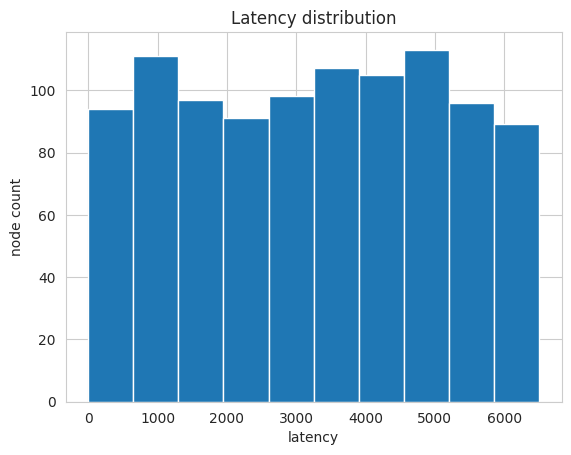

In [41]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

count    1001.000000
mean        0.999001
std         0.054763
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: received_packets, dtype: float64


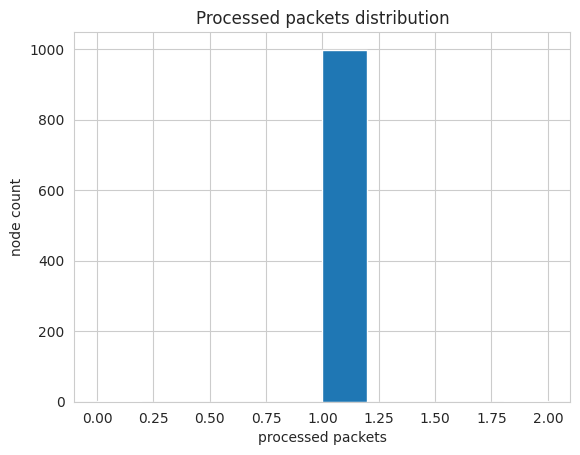

In [42]:
df_stats["received_packets"].hist()
plt.xlabel("processed packets")
plt.ylabel("node count")
plt.title("Processed packets distribution")
print(df_stats["received_packets"].describe())

eval_matrix["chain"] = df_stats.copy()

In [43]:
np.where(received_packets_hist > 1)

(array([0]),)

### Experiment 4: Calculating the minimum spanning tree like in PEDAP

In [44]:
df = prim_df.copy()
mst = prim_mst(coords)

In [45]:
print(mst)

[-1, 570, 566, 645, 888, 297, 351, 557, 150, 917, 665, 86, 319, 725, 232, 108, 135, 453, 103, 591, 460, 256, 39, 268, 188, 253, 917, 83, 556, 982, 604, 310, 94, 909, 579, 338, 447, 421, 199, 229, 855, 184, 484, 110, 952, 689, 315, 477, 402, 139, 686, 489, 341, 828, 258, 5, 768, 748, 230, 211, 98, 249, 376, 450, 70, 564, 407, 52, 22, 549, 398, 525, 576, 700, 929, 155, 639, 879, 286, 411, 53, 983, 649, 259, 43, 300, 393, 768, 246, 280, 754, 384, 308, 821, 251, 661, 668, 533, 958, 664, 914, 377, 902, 706, 366, 559, 92, 822, 527, 876, 971, 759, 262, 807, 6, 620, 803, 226, 546, 964, 420, 218, 683, 999, 813, 409, 629, 615, 278, 960, 865, 26, 455, 32, 449, 870, 395, 743, 714, 946, 225, 99, 819, 691, 675, 603, 456, 110, 392, 896, 189, 445, 296, 724, 16, 84, 839, 410, 831, 87, 698, 780, 235, 901, 491, 15, 524, 681, 372, 541, 664, 853, 460, 217, 406, 631, 368, 589, 346, 615, 602, 134, 611, 114, 70, 551, 6, 127, 390, 431, 82, 378, 138, 801, 765, 122, 877, 727, 863, 627, 301, 693, 522, 292, 57, 91

In [46]:
routes = createRoutes(mst)
print(routes[3])

[645, 224, 344, 812, 222, 1000, 234, 116, 803, 670, 206, 355, 323, 360, 554, 495, 362, 37, 421, 850, 771, 787, 929, 766, 763, 599, 165, 15, 108, 527, 905, 510, 900, 365, 581, 994, 642, 985, 533, 582, 970, 418, 63, 450, 568, 939, 394, 416, 741, 507, 260, 973, 295, 632, 710, 933, 932, 881, 896, 441, 458, 577, 948, 845, 721, 545, 660, 695, 487, 993, 258, 718, 657, 326, 0]


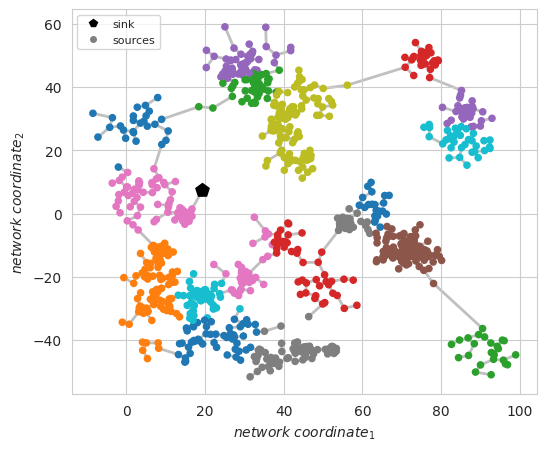

In [47]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(1, len(mst)):
    point1 = coords[i]
    point2 = coords[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=colors[labels], ax=fig)
fig.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/sim_1000/mst.svg", bbox_inches="tight")
plt.show()

In [48]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
for i in range(1, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = routes[i]
    start = i
    for j in range(0, len(lat_route)):
        end = lat_route[j]
        dist = dist + np.linalg.norm(coords[start] - coords[end])
        start = end
    latency_hist[i] = dist

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    received_packets_hist[mst[i]] += 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

count    1001.000000
mean      134.163517
std        57.300994
min         0.000000
25%        95.302957
50%       132.110373
75%       178.794881
max       277.576865
Name: latency_distribution, dtype: float64


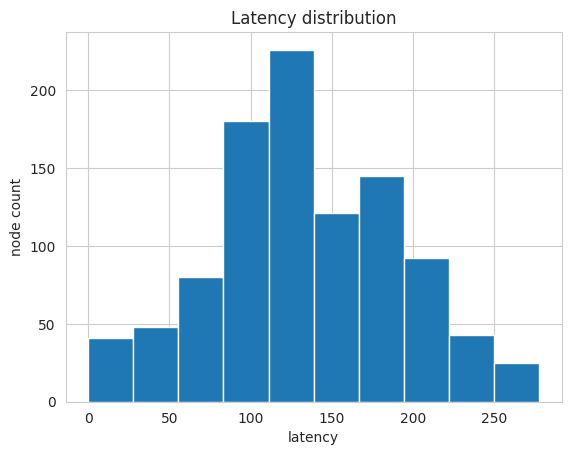

In [49]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

Distribution of workload:  77.023 %


Text(0.5, 1.0, 'Processed packets distribution')

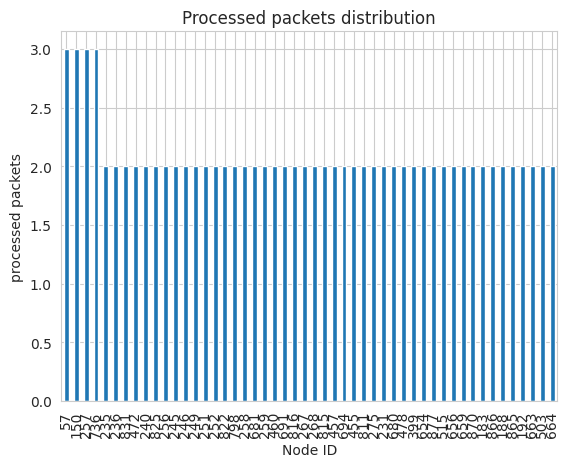

In [50]:
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")

df_packets = df_packets.head(int(round(device_number * 0.05)))
df_packets.plot.bar()

plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution")

In [51]:
eval_matrix["mst"] = df_stats.copy()

## Evaluation

In [126]:
eval_matrix.keys()

dict_keys(['dt', 'leach', 'nemo_dc_weight_2', 'nemo_dc_weight', 'nemo_dc', 'chain', 'mst'])

In [127]:
eval_matrix["nemo_dc"].keys()

dict_keys(['capacity_100', 'capacity_90', 'capacity_80', 'capacity_70', 'capacity_60', 'capacity_50', 'capacity_40', 'capacity_30', 'capacity_20', 'capacity_10', 'capacity_5', 'capacity_1'])

In [128]:
aggregation_fams = ["dt", "leach", "mst", "chain"]
heterogen_appr = ['nemo_dc', 'nemo_dc_weight_2', 'nemo_dc_weight']

#### Latency

In [129]:
heterogen_appr

['nemo_dc', 'nemo_dc_weight_2', 'nemo_dc_weight']

In [130]:
eval_colors = {
    "dt": colors[0],
    "leach": colors[1],
    "mst": colors[2],
    "chain": colors[3],
    "nemo": colors[4],
    "nemo_base": colors[4],
    "nemo_dc_base": colors[4],
    "NEMO_base": colors[4],
    "nemo_rc": colors[5],
    "nemo_rc_base": colors[5],
    "nemo (rdm groups)_base": colors[5],
    "nemo_dc": colors[6],
    "NEMO+redistribution": colors[6],
    "nemo_pen": colors[7],
    "nemo_pen_base": colors[8],
    "nemo_dc_weight_2": colors[9],
    "nemo_dc_weight": colors[10]
}

renaming_dict = {
    "nemo_dc": "nemo (w=1,",
    "nemo_dc_weight_2": "nemo (w=2,",
    "nemo_dc_weight": "nemo (w=ln[1, 50],",
    "capacity_100": "m=" + first_med_label,
    "capacity_1": "m=" + last_med_label
}


In [131]:
eval_matrix["dt"]["latency_distribution"].mean()

42.07131822601497

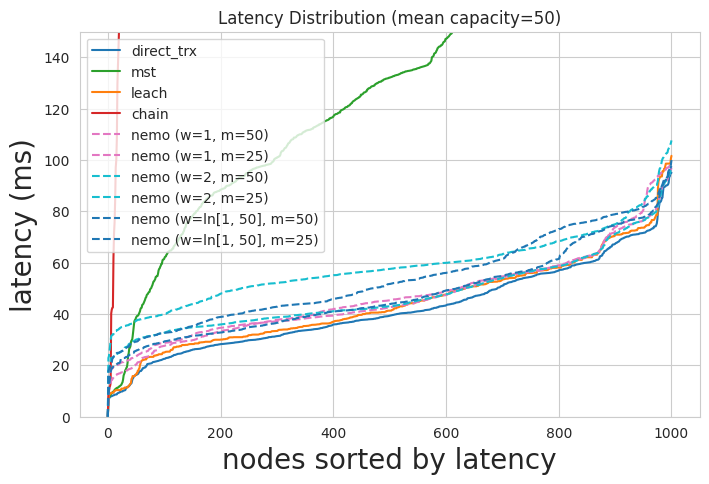

Means:  {'dt': 42.07, 'mst': 134.16, 'leach': 44.49, 'chain': 3256.18, 'nemo (w=1, m=50)': 46.59, 'nemo (w=1, m=25)': 47.39, 'nemo (w=2, m=50)': 47.76, 'nemo (w=2, m=25)': 58.43, 'nemo (w=ln[1, 50], m=50)': 47.82, 'nemo (w=ln[1, 50], m=25)': 53.73}
Quantiles:  {'dt': 67.35, 'mst': 215.28, 'leach': 70.93, 'chain': 5782.98, 'nemo (w=1, m=50)': 72.23, 'nemo (w=1, m=25)': 73.73, 'nemo (w=2, m=50)': 71.31, 'nemo (w=2, m=25)': 74.96, 'nemo (w=ln[1, 50], m=50)': 74.69, 'nemo (w=ln[1, 50], m=25)': 78.88}


In [132]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

#plot baselines
for l in ["dt", "mst", "leach", "chain"]:
    orl = l
    sv = eval_matrix[l]["latency_distribution"].sort_values()
    #print("Mean latency ", l, ": ", round(eval_matrix[l]["latency_distribution"].mean(), 2))
    quant_dict[l] = round(eval_matrix[l]["latency_distribution"].quantile(0.9), 2)
    mean_dict[l] = round(eval_matrix[l]["latency_distribution"].mean(), 2)

    if l == "dt":
        l = "direct_trx"
    sv.plot(ax=ax1, linestyle="-", use_index=False, label=l, color=eval_colors[orl])

for approach in heterogen_appr:
    cl = approach
    emat = eval_matrix[approach]

    for capacity, df in emat.items():
        if capacity not in ["capacity_100", "capacity_1"]:
            continue
        l = renaming_dict[approach] + " " + renaming_dict[capacity] + ")"

        sv = df["latency_distribution"].sort_values()
        quant_dict[l] = round(sv.quantile(0.9), 2)
        mean_dict[l] = round(sv.mean(), 2)
        sv.plot(ax=ax1, use_index=False, label=l, color=eval_colors[cl], linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})
# Display a figure.
plt.ylim([0, 150])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

#### Heterogeneity

In [133]:
aggregation_fams

['dt', 'leach', 'mst', 'chain']

In [134]:
eval_matrix_load = eval_matrix.copy()
eval_matrix_load.pop("nemo_dc_weight_2")
eval_matrix_load.pop("nemo_dc_weight")
eval_matrix_load.keys()

dict_keys(['dt', 'leach', 'nemo_dc', 'chain', 'mst'])

In [135]:
load_dict = {}
nn_dict = {}

for k, df in eval_matrix_load.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in slot_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in slot_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

In [136]:
load_dict

{'dt': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'leach': [1.05, 1.05, 1.05, 1.05, 1.1, 1.2, 1.35, 1.55, 1.6, 3.1, 6.85, 23.4],
 'chain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 69],
 'mst': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 51]}

In [137]:
load_dict = {}
nn_dict = {}

for k, df in eval_matrix_load.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in slot_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in slot_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

for k, mat in eval_matrix_load.items():
    if k in heterogen_appr:
        slot_list = []
        nn_list = []
        for colname in slot_columns:
            df = mat[colname]
            df["av_capacity"] = prim_df[colname] - df["received_packets"]
            tmp_df_sl = df[df["av_capacity"] < 0]
            tmp_df_nn = df[df["av_capacity"] >= 0]
            slot_list.append(tmp_df_sl["av_capacity"].count())
            nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

#for k, mat in eval_matrix.items():
#    if k in heterogen_appr:
#        slot_list = []
#        nn_list = []
#        for colname in slot_columns:
#            df = mat["base"]
#            df["av_capacity"] = prim_df[colname] - df["received_packets"]
#            tmp_df_sl = df[df["av_capacity"] < 0]
#            tmp_df_nn = df[df["av_capacity"] >= 0]
#            slot_list.append(tmp_df_sl["av_capacity"].count())
#            nn_list.append(tmp_df_nn["av_capacity"].count())
#        load_dict[k + "_base"] = slot_list
#        nn_dict[k + "_base"] = nn_list

In [138]:
load_dict.keys()

dict_keys(['dt', 'leach', 'chain', 'mst', 'nemo_dc'])

In [139]:
agg_arr1 = []
for fam in eval_matrix_load.keys():
    agg_arr1.append(load_dict[fam])
    print("Fam: ", fam)
    print(load_dict[fam])

#agg_arr2 = []
#for fam in eval_matrix_load.keys():
#    agg_arr2.append(load_dict[fam + "_base"])
#mr = np.mean(np.array(agg_arr2), axis=0)
#load_dict["NEMO_base"] = mr
#print(mr)

Fam:  dt
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Fam:  leach
[1.05, 1.05, 1.05, 1.05, 1.1, 1.2, 1.35, 1.55, 1.6, 3.1, 6.85, 23.4]
Fam:  nemo_dc
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Fam:  chain
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 69]
Fam:  mst
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 51]


dt [50. 51. 50. 49. 49. 49. 47. 44. 42. 37. 32. 24.]
dt [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
leach [50. 51. 50. 49. 49. 49. 47. 44. 42. 37. 32. 24.]
leach [1.05, 1.05, 1.05, 1.05, 1.1, 1.2, 1.35, 1.55, 1.6, 3.1, 6.85, 23.4]
chain [50. 51. 50. 49. 49. 49. 47. 44. 42. 37. 32. 24.]
chain [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 69]
mst [50. 51. 50. 49. 49. 49. 47. 44. 42. 37. 32. 24.]
mst [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 51]
nemo_dc [50. 51. 50. 49. 49. 49. 47. 44. 42. 37. 32. 24.]
nemo_dc [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


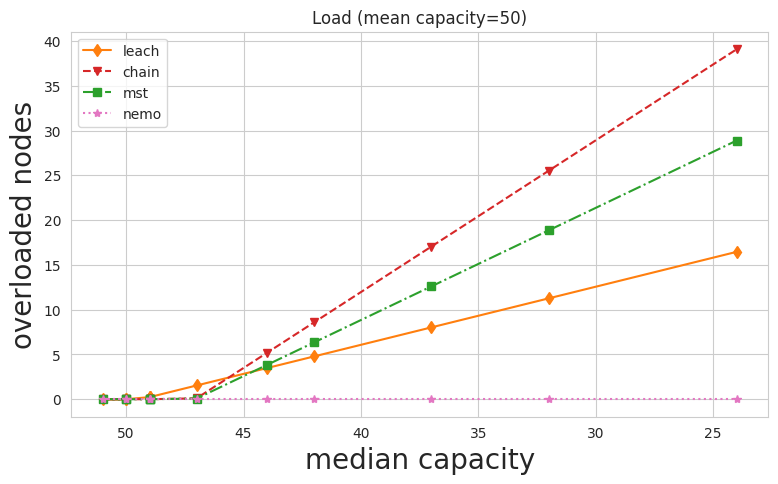

In [140]:
fig, ax = plt.subplots(figsize=(9, 5))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in load_dict.keys():
    vals = load_dict[fam]
    evcol = fam
    print(fam, medians)
    print(fam, vals)
    m, b = np.polyfit(medians, vals, 1)
    if fam == "dt":
        fam = "direct_trx"
        continue
    if fam == "nemo_dc":
        fam = "nemo"
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median capacity")
ax.set_ylabel("overloaded nodes")
#ax.set_yscale('log')
ax.legend()

ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

plt.savefig("plots/sim_1000/eval_load_abs.svg")
ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()


In [141]:
load_dict.keys()

dict_keys(['dt', 'leach', 'chain', 'mst', 'nemo_dc'])

leach - d #ff7f0e : [1.05, 1.05, 1.05, 1.05, 1.1, 1.2, 1.35, 1.55, 1.6, 3.1, 6.849999999999999, 23.4]
chain -- v #d62728 : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.906906906906906]
mst -. s #2ca02c : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.2]
nemo : * #e377c2 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


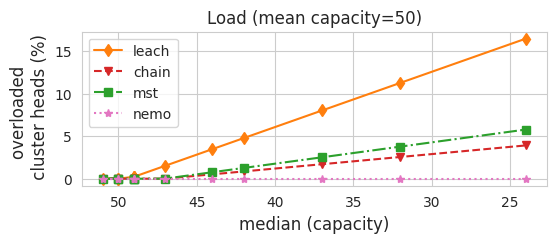

In [142]:
fig, ax = plt.subplots(figsize=(6, 2))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in load_dict.keys():
    vals = load_dict[fam]
    evcol = fam
    if fam == "dt":
        fam = "direct_trx"
        vals = [100 for x in vals]
        continue
    if fam == "leach":
        vals = [x / num_leach_clusters * 100 for x in vals]
    if fam == "mst":
        agg_points = (device_number - 1) / 2
        vals = [x / agg_points * 100 for x in vals]
    if fam == "chain":
        agg_points = device_number - 2
        vals = [x / agg_points * 100 for x in vals]
    if fam == "nemo_dc":
        fam = "nemo"
    m, b = np.polyfit(medians, vals, 1)
    print(fam, styles[i], markers[i], eval_colors[evcol], ":", vals)
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median (capacity)")
ax.set_ylabel("overloaded \n cluster heads (%)")
#ax.set_yscale('log')
ax.legend()

ax.yaxis.label.set_size(12)
ax.xaxis.label.set_size(12)

plt.savefig("plots/sim_1000/eval_load_perc.svg")
ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()

In [143]:
quant_dict

{'dt': 67.35,
 'mst': 215.28,
 'leach': 70.93,
 'chain': 5782.98,
 'nemo (w=1, m=50)': 72.23,
 'nemo (w=1, m=25)': 73.73,
 'nemo (w=2, m=50)': 71.31,
 'nemo (w=2, m=25)': 74.96,
 'nemo (w=ln[1, 50], m=50)': 74.69,
 'nemo (w=ln[1, 50], m=25)': 78.88}

In [144]:
mean_dict

{'dt': 42.07,
 'mst': 134.16,
 'leach': 44.49,
 'chain': 3256.18,
 'nemo (w=1, m=50)': 46.59,
 'nemo (w=1, m=25)': 47.39,
 'nemo (w=2, m=50)': 47.76,
 'nemo (w=2, m=25)': 58.43,
 'nemo (w=ln[1, 50], m=50)': 47.82,
 'nemo (w=ln[1, 50], m=25)': 53.73}